#### 2. Сбор данных с ArXiv

Тематика научных публикаций: Computation and Language

In [1]:
import requests
import xml.etree.ElementTree as et
import pandas as pd

def fetch_arxiv_papers(category='cs.CL', max_results=1000):
    base_url = 'https://export.arxiv.org/api/query?'
    papers = []

    batch_size = 50
    for start in range(0, max_results, batch_size):
        query = f'search_query=cat:{category}&start={start}&max_results={batch_size}'
        url = base_url + query

        response = requests.get(url)
        if response.status_code == 200:
            root = et.fromstring(response.content)

            for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
                paper = {
                    'id': entry.find('{http://www.w3.org/2005/Atom}id').text,
                    'title': entry.find('{http://www.w3.org/2005/Atom}title').text.strip(),
                    'summary': entry.find('{http://www.w3.org/2005/Atom}summary').text.strip(),
                    'authors': [author.find('{http://www.w3.org/2005/Atom}name').text 
                               for author in entry.findall('{http://www.w3.org/2005/Atom}author')],
                    'published': entry.find('{http://www.w3.org/2005/Atom}published').text
                }
                papers.append(paper)

    return pd.DataFrame(papers)

df_papers = fetch_arxiv_papers()
print(f"Загружено {len(df_papers)} публикаций")

Загружено 1000 публикаций


#### 3. Извлечение ключевых слов по каждой публикации

In [2]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')      # Модель для токенизации
nltk.download('punkt_tab')  # Дополнительные данные для токенизации
nltk.download('stopwords')  # Список стоп-слов
nltk.download('wordnet')
nltk.download('omw-1.4')

def extract_keywords(text, n_keywords=10):
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words and len(token) > 2]
    
    if not filtered_tokens:
        return []
    
    text_cleaned = ' '.join(filtered_tokens)
    
    # Создание TF-IDF векторизатора
    # max_features - максимальное число ключевых слов
    # ngram_range=(1, 2) - учитывать как отдельные слова, так и пары слов
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    
    try:
        # Преобразование текста в TF-IDF матрицу
        tfidf_matrix = vectorizer.fit_transform([text_cleaned])
        # Получение списка всех слов/словосочетаний
        feature_names = vectorizer.get_feature_names_out()
        
        # Получение TF-IDF оценок для каждого слова
        tfidf_scores = tfidf_matrix.toarray()[0]
        
        # Создание пар (слово, оценка)
        keyword_scores = list(zip(feature_names, tfidf_scores))
        # Сортировка по убыванию оценки TF-IDF = TF × IDF
        keyword_scores.sort(key=lambda x: x[1], reverse=True)
        
        return [kw[0] for kw in keyword_scores[:n_keywords]]
    except:
        return []

df_papers['keywords'] = df_papers.apply(
    lambda row: extract_keywords(row['title'] + ' ' + row['summary'], n_keywords=15), 
    axis=1
)

print(df_papers['keywords'])

[nltk_data] Downloading package punkt to /Users/dlavrenov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dlavrenov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dlavrenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dlavrenov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dlavrenov/nltk_data...


0      [segment, document, present, segmentation, ter...
1      [dialog, coherence, participant, utterance, ac...
2      [grammar, xtag, report, described, english, gr...
3      [prefix, probability, grammar, stochastic, a_1...
4      [probabilistic, condition, grammar, probabilit...
                             ...                        
995    [embeddings, word, autoextend, lexeme, synset,...
996    [data, analysis, solr, term, correspondence, f...
997    [sentiment, opinion, analysis, opinion analysi...
998    [language, natural, classification, natural la...
999    [language, based, transfer, transfer based, en...
Name: keywords, Length: 1000, dtype: object


#### 4. Построение связей между ключевыми словами на основе их принадлежности публикациям

In [3]:
import networkx as nx
from collections import Counter

def build_keyword_graph(df_papers):
    # Пустой неориентированный граф
    G = nx.Graph()
    
    all_keywords = []
    for keywords in df_papers['keywords']:
        all_keywords.extend(keywords)
    
    keyword_freq = Counter(all_keywords)
    
    for keyword, freq in keyword_freq.items():
        if freq >= 3:
            G.add_node(keyword, weight=freq) # Вес узла - как часто встречается слово в разных статьях 
    
    for keywords in df_papers['keywords']:
        filtered_keywords = [kw for kw in keywords if kw in G.nodes()]
        
        for i in range(len(filtered_keywords)):
            for j in range(i + 1, len(filtered_keywords)):
                kw1, kw2 = filtered_keywords[i], filtered_keywords[j]
                
                if G.has_edge(kw1, kw2):
                    G[kw1][kw2]['weight'] += 1 # Вес ребра - сколько раз пары слов встречаются вместе в одной статье
                else:
                    G.add_edge(kw1, kw2, weight=1)
    
    return G

G_keywords = build_keyword_graph(df_papers)
print(f"Граф содержит {G_keywords.number_of_nodes()} узлов и {G_keywords.number_of_edges()} ребер")

Граф содержит 896 узлов и 28071 ребер


#### 5. Определение кластеров ключевых слов на графе

In [4]:
from networkx.algorithms import community

def cluster_and_evaluate(G):
    communities = community.louvain_communities(G, weight='weight')
    
    modularity = community.modularity(G, communities, weight='weight')
    
    print(f"Найдено {len(communities)} кластеров")
    print(f"Модулярность: {modularity:.3f}")
    
    for i, cluster in enumerate(communities):
        if len(cluster) > 5:
            subgraph = G.subgraph(cluster)
            centrality = nx.degree_centrality(subgraph)
            top_words = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
            
            print(f"\nКластер {i+1} ({len(cluster)} слов):")
            print("Ключевые слова:", [word for word, _ in top_words])
    
    return communities, modularity

communities, modularity = cluster_and_evaluate(G_keywords)

Найдено 11 кластеров
Модулярность: 0.167

Кластер 1 (82 слов):
Ключевые слова: ['model', 'information', 'speech', 'recognition', 'document']

Кластер 2 (91 слов):
Ключевые слова: ['based', 'algorithm', 'approach', 'feature', 'arabic']

Кластер 3 (76 слов):
Ключевые слова: ['language', 'natural', 'natural language', 'controlled', 'processing']

Кластер 4 (42 слов):
Ключевые слова: ['finite', 'finite state', 'state', 'computational', 'automaton']

Кластер 5 (78 слов):
Ключевые слова: ['text', 'analysis', 'also', 'application', 'sentiment']

Кластер 6 (146 слов):
Ключевые слова: ['word', 'method', 'semantic', 'learning', 'representation']

Кластер 7 (130 слов):
Ключевые слова: ['system', 'translation', 'machine', 'english', 'machine translation']

Кластер 8 (34 слов):
Ключевые слова: ['entity', 'named entity', 'named', 'task', 'entity recognition']

Кластер 9 (110 слов):
Ключевые слова: ['corpus', 'data', 'annotation', 'resource', 'linguistic']

Кластер 10 (18 слов):
Ключевые слова: ['for

1. Модулярность 0.195:
    - Положительное значение (>0) показывает, что разделение на кластеры имеет смысл
    - Не очень высокое значение объяснимо тем, что области сильно пересекаются   
         
    Слова внутри одного кластера связаны друг с другом сильнее, чем со словами из других кластеров. Но области исследований в компьютерной лингвистике сильно связаны. Те, статья о машинном переводе (Кластер 7) возможно будет использовать какие-то "model" (Кластер 1) и обучаться на "data" (Кластер 9). Из-за этих пересечений кластеры не получаются идеально изолированными, что и отражает невысокая модулярность.

2. Кластеры имеют четкую тематическую направленность

    Например, кластер 1 описывает применение машинного обучения (те тут используются общие слова для этой оболасти знаний), кластер 2 состоит из слов, которыми описывают как что-то делается (algorithm, based,...), кластер 3 описывает обработку естественного языка, кластер 4 - математические термины, и тд.

3. Размеры кластеров:
    - Большие кластеры (>100 слов) для основных направлений
    - Маленькие кластеры для узких специализаций

#### 6. Cлова с наибольшими значениями центральности

In [5]:
def analyze_centrality(G, top_n=10):
    degree_cent = nx.degree_centrality(G)

    betweenness_cent = nx.betweenness_centrality(G, weight='weight')
    
    try:
        eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    except:
        eigenvector_cent = {}
    
    closeness_cent = nx.closeness_centrality(G, distance='weight')
    
    centrality_df = pd.DataFrame({
        'keyword': list(G.nodes()),
        'degree': [degree_cent.get(node, 0) for node in G.nodes()],
        'betweenness': [betweenness_cent.get(node, 0) for node in G.nodes()],
        'eigenvector': [eigenvector_cent.get(node, 0) for node in G.nodes()],
        'closeness': [closeness_cent.get(node, 0) for node in G.nodes()]
    })
    
    print("Топ ключевых слов по различным мерам центральности:")
    
    for measure in ['degree', 'betweenness', 'eigenvector', 'closeness']:
        print(f"\n{measure.capitalize()} Centrality:")
        top_keywords = centrality_df.nlargest(top_n, measure)[['keyword', measure]]
        print(top_keywords.to_string(index=False))
    
    return centrality_df

centrality_results = analyze_centrality(G_keywords)

Топ ключевых слов по различным мерам центральности:

Degree Centrality:
  keyword   degree
 language 0.791061
    based 0.620112
     word 0.601117
    model 0.569832
   system 0.520670
 approach 0.519553
   method 0.497207
     text 0.482682
   corpus 0.433520
algorithm 0.431285

Betweenness Centrality:
 keyword  betweenness
language     0.036915
   based     0.026673
  system     0.025769
approach     0.024516
   model     0.022607
    text     0.022512
  method     0.020874
    word     0.020327
analysis     0.019957
  corpus     0.019637

Eigenvector Centrality:
    keyword  eigenvector
   language     0.409264
       word     0.271214
      based     0.271176
      model     0.266424
   approach     0.203521
     system     0.189235
     method     0.178992
       text     0.160450
translation     0.145789
     corpus     0.142613

Closeness Centrality:
  keyword  closeness
 language   0.581925
   system   0.577047
 approach   0.576675
    based   0.570427
   corpus   0.570427
   

1. Сколько связей у слова (Degree Centrality) - какие слова используются чаще всего:
    - "language" встречается чаще всего, используется везде
    - "based" часто используется как часть других терминов
    - "word" - простое, но важное слово в этой области
    
2. Насколько слово помогает связать другие слова (Betweenness Centrality) - метрика показывает слова-мостики между разными темами:
    - "language" связывает разные темы между собой
    - "based", "system", "approach" - помогают описать, как одни вещи связаны с другими

3. Связь с другими важными словами (Eigenvector Centrality) - метрика показывает самые важные слова в области:
    - "language", "word", "based" часто используются с другими важными словами
    - "model", "approach", "system" - основные рабочие термины
    
4. Как близко слово ко всем остальным (Closeness Centrality) - метрика показывает слова, которые используются везде:
    - Все слова довольно близки друг к другу
    - "language", "approach", "based" - встречаются во всех темах

- "language" - центральный термин области по всем метрикам
- Методологические термины ("based", "approach", "system") важны как связующие звенья
- Технические термины ("model", "translation") важны в контексте связей с другими важными терминами
- Базовые лингвистические термины ("word", "text") имеют высокую степень связности

#### 7. Граф публикаций

In [14]:
def build_publication_graph(df_papers):
    G_pub = nx.Graph()
    
    for idx, row in df_papers.iterrows():
        G_pub.add_node(idx, title=row['title'], keywords=set(row['keywords']))
    
    for i in range(len(df_papers)):
        keywords_i = set(df_papers.iloc[i]['keywords'])
        
        for j in range(i + 1, len(df_papers)):
            keywords_j = set(df_papers.iloc[j]['keywords'])
            
            common_keywords = keywords_i.intersection(keywords_j)
            
            if len(common_keywords) > 0:
                G_pub.add_edge(i, j, weight=len(common_keywords), 
                             common_keywords=list(common_keywords))
    
    return G_pub

def find_similar_publications(G_pub, df_papers, paper_idx, top_n=5):
    if paper_idx not in G_pub.nodes():
        return []
    
    neighbors = []
    for neighbor in G_pub.neighbors(paper_idx):
        weight = G_pub[paper_idx][neighbor]['weight']
        neighbors.append((neighbor, weight))
    
    neighbors.sort(key=lambda x: x[1], reverse=True)
    
    similar_papers = []
    for idx, weight in neighbors[:top_n]:
        similar_papers.append({
            'index': idx,
            'title': df_papers.iloc[idx]['title'],
            'common_keywords_count': weight,
            'common_keywords': G_pub[paper_idx][idx]['common_keywords']
        })
    
    return similar_papers

G_publications = build_publication_graph(df_papers)
print(f"Граф публикаций: {G_publications.number_of_nodes()} узлов, {G_publications.number_of_edges()} ребер")

paper_idx = 9
print(f"\nПубликация: {df_papers.iloc[paper_idx]['title']}")
print("\nПохожие публикации:")

similar = find_similar_publications(G_publications, df_papers, paper_idx)
for i, paper in enumerate(similar, 1):
    print(f"\n{i}. {paper['title']}")
    print(f"   Общих ключевых слов: {paper['common_keywords_count']}")
    print(f"   Ключевые слова: {', '.join(paper['common_keywords'][:5])}")

Граф публикаций: 1000 узлов, 173452 ребер

Публикация: Computing Declarative Prosodic Morphology

Похожие публикации:

1. One-Level Prosodic Morphology
   Общих ключевых слов: 6
   Ключевые слова: finite state, prosodic, prosodic morphology, morphology, state

2. Finite-State Reduplication in One-Level Prosodic Morphology
   Общих ключевых слов: 6
   Ключевые слова: finite state, prosodic, prosodic morphology, morphology, state

3. Temiar Reduplication in One-Level Prosodic Morphology
   Общих ключевых слов: 6
   Ключевые слова: finite state, approach, prosodic, prosodic morphology, morphology

4. Morphological Analysis of the Bishnupriya Manipuri Language using Finite
  State Transducers
   Общих ключевых слов: 5
   Ключевые слова: finite state, approach, morphology, state, finite

5. Approximation and Exactness in Finite State Optimality Theory
   Общих ключевых слов: 4
   Ключевые слова: finite, finite state, constraint, state


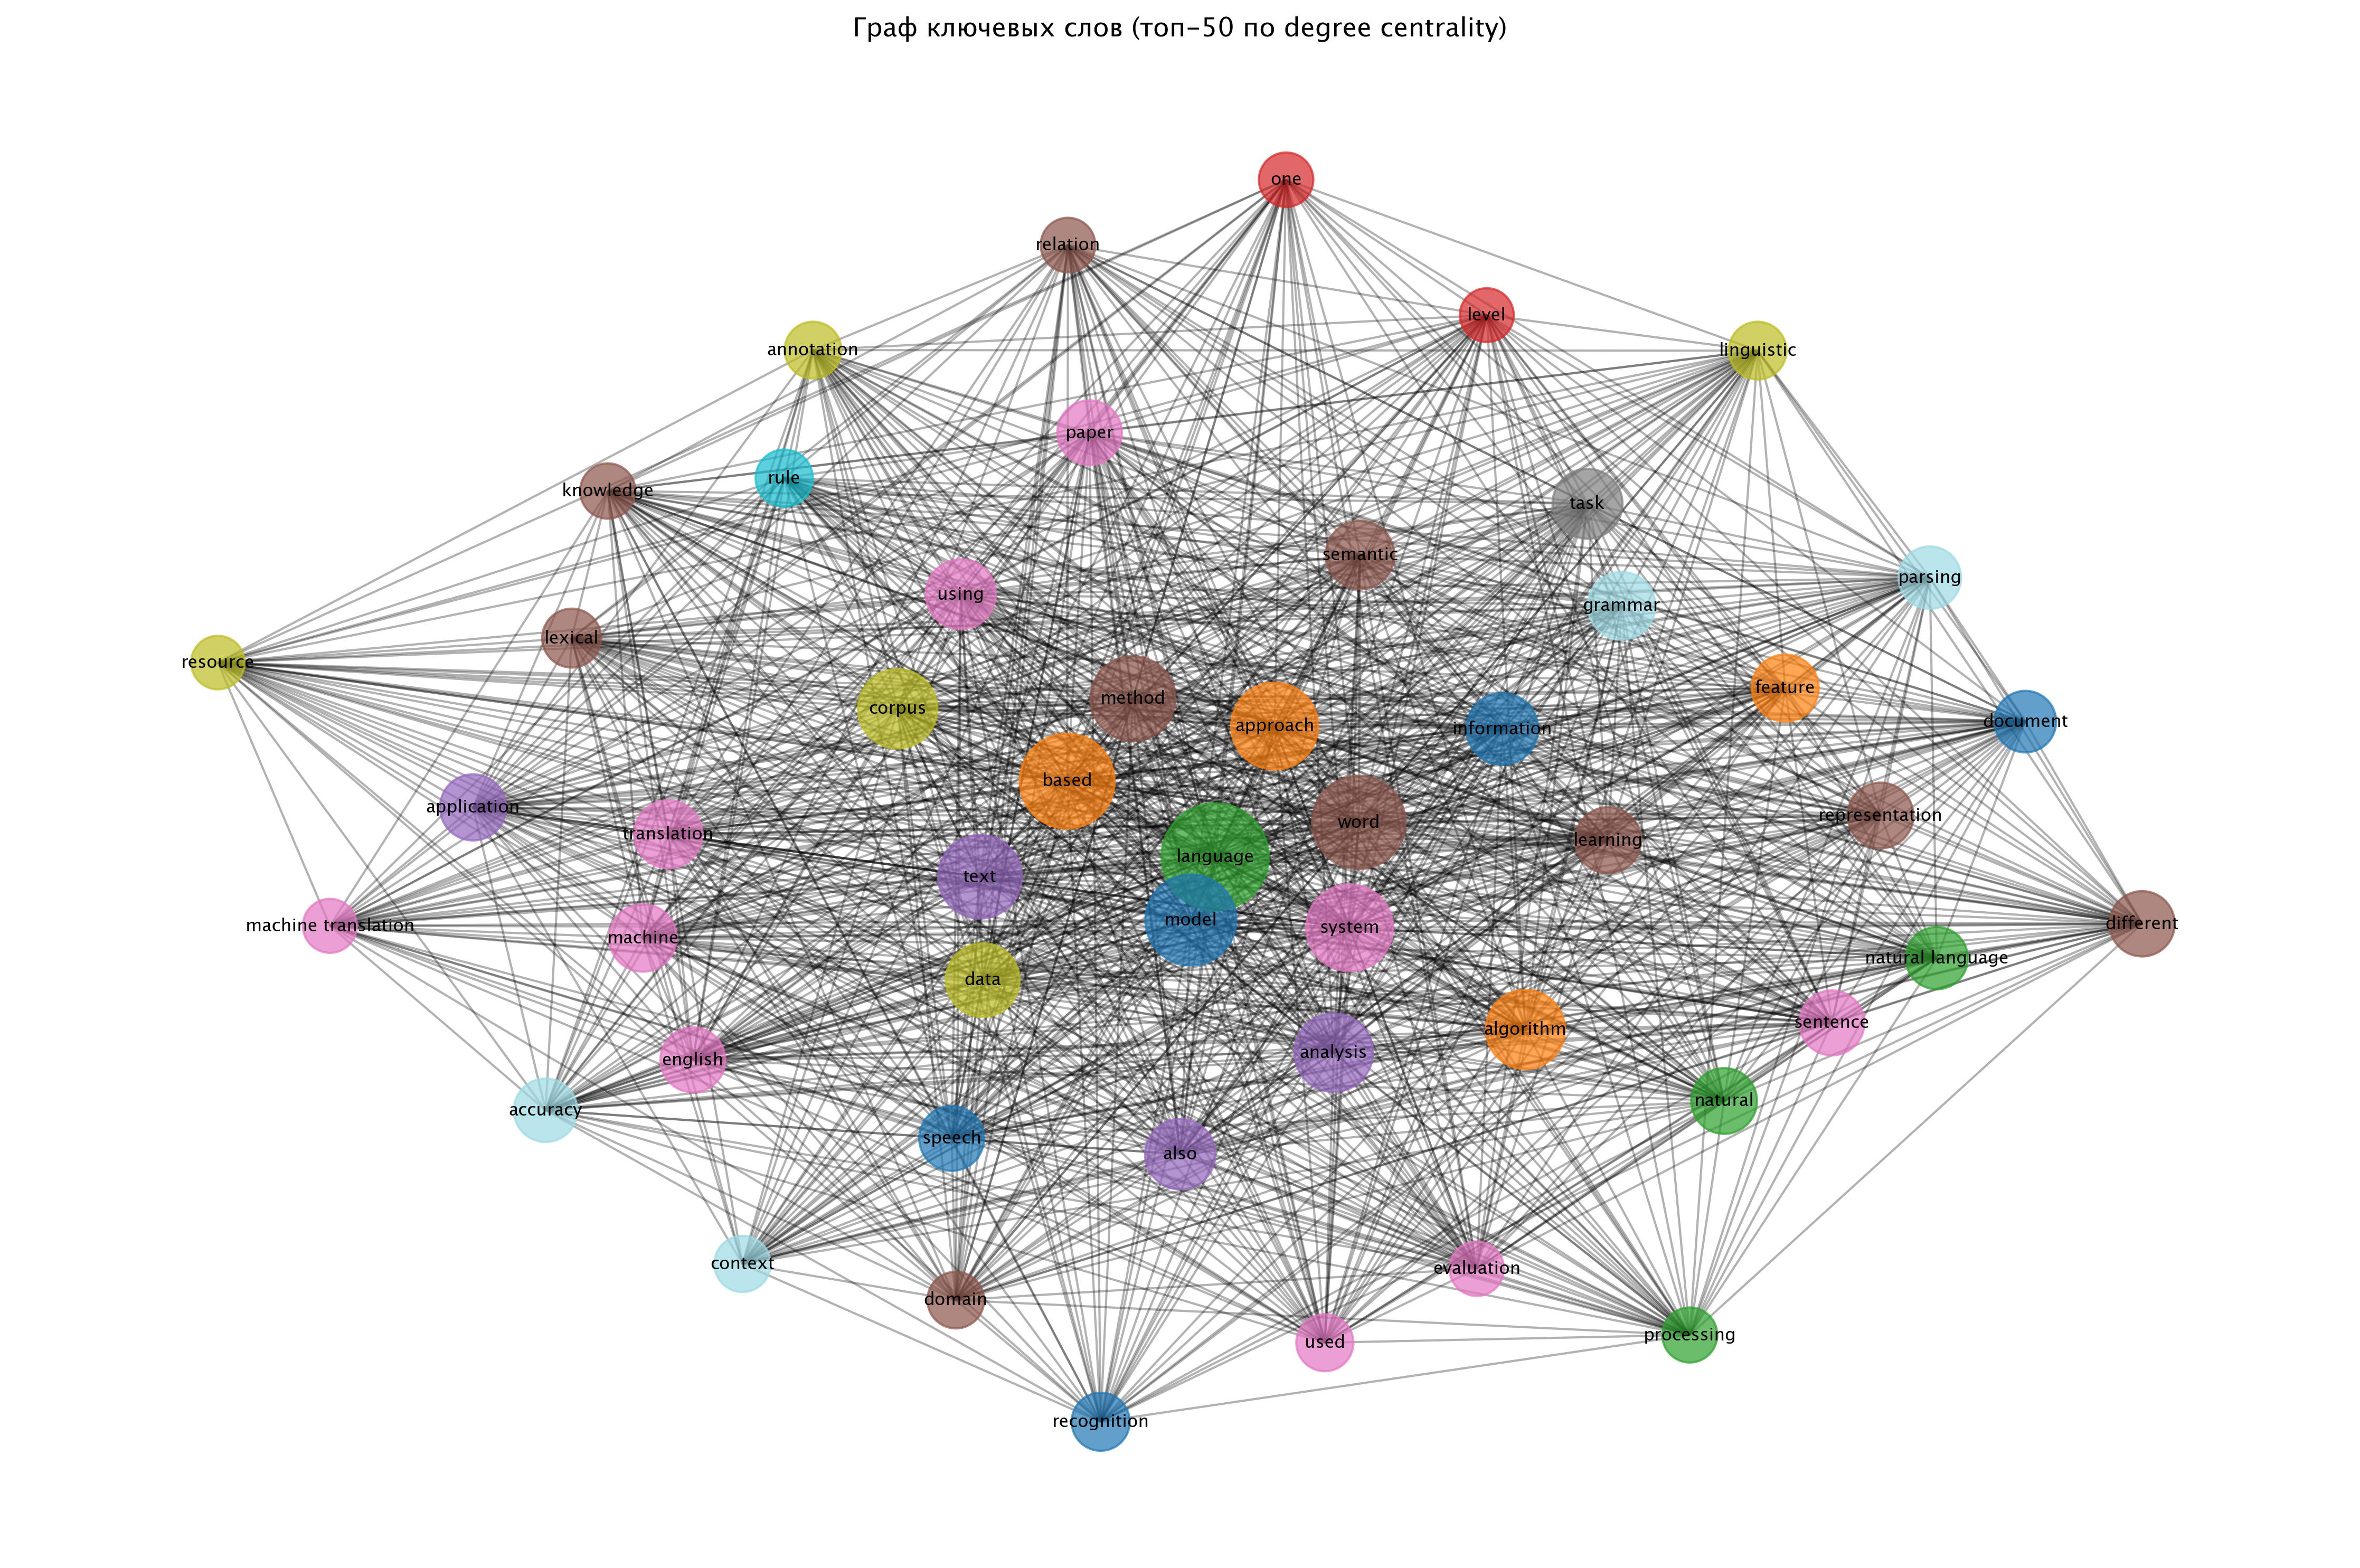

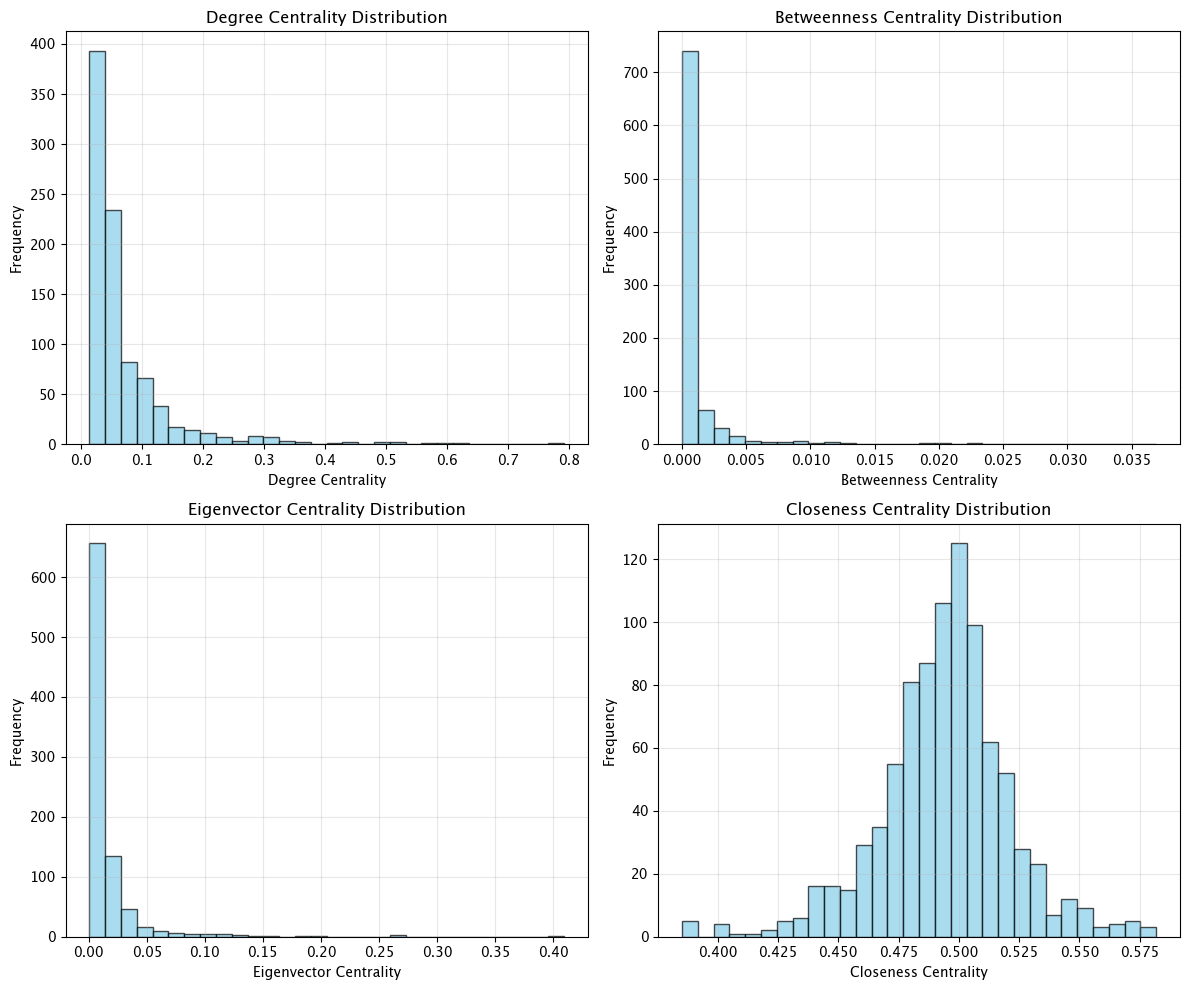

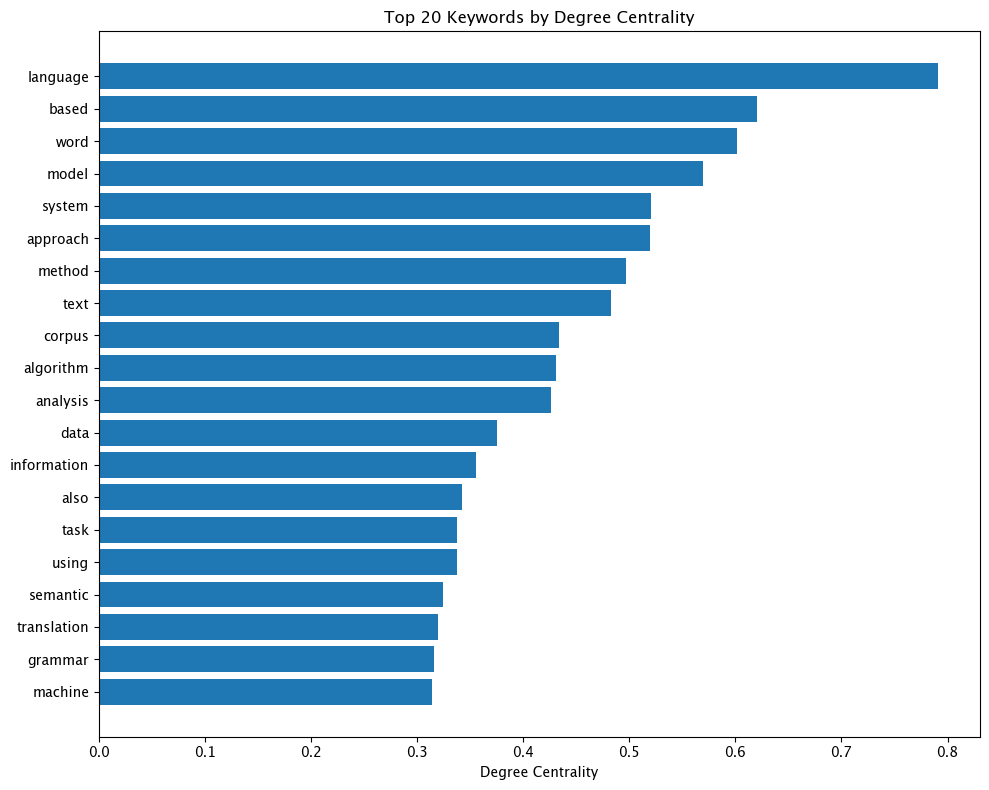


=== ИТОГОВАЯ СТАТИСТИКА ===
Всего публикаций: 1000
Уникальных ключевых слов: 5667
Узлов в графе ключевых слов: 896
Ребер в графе ключевых слов: 28071
Количество кластеров: 11
Модулярность кластеризации: 0.167
Узлов в графе публикаций: 1000
Ребер в графе публикаций: 173452


In [7]:
import matplotlib.pyplot as plt

def visualize_keyword_graph(G, communities=None, top_n=50):
    degree_cent = nx.degree_centrality(G)
    top_nodes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = [node for node, _ in top_nodes]
    
    G_sub = G.subgraph(top_node_names)
    
    plt.figure(figsize=(15, 10), dpi=300)
    
    if communities:
        node_colors = []
        for node in G_sub.nodes():
            for i, community in enumerate(communities):
                if node in community:
                    node_colors.append(i)
                    break
    else:
        node_colors = 'lightblue'
    
    node_sizes = [degree_cent[node] * 3000 for node in G_sub.nodes()]
    
    pos = nx.spring_layout(G_sub, k=1, iterations=50)
    
    nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, 
                          node_size=node_sizes, alpha=0.7, cmap='tab20')
    nx.draw_networkx_labels(G_sub, pos, font_size=8)
    nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
    
    plt.title("Граф ключевых слов (топ-50 по degree centrality)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_keyword_graph(G_keywords, communities=communities, top_n=50)

def plot_centrality_distributions(centrality_df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    measures = ['degree', 'betweenness', 'eigenvector', 'closeness']
    
    for i, measure in enumerate(measures):
        axes[i].hist(centrality_df[measure], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{measure.capitalize()} Centrality Distribution')
        axes[i].set_xlabel(f'{measure.capitalize()} Centrality')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_centrality_distributions(centrality_results)


def plot_top_keywords(centrality_df, measure='degree', top_n=20):
    plt.figure(figsize=(10, 8))
    
    top_keywords = centrality_df.nlargest(top_n, measure)
    
    plt.barh(range(len(top_keywords)), top_keywords[measure])
    plt.yticks(range(len(top_keywords)), top_keywords['keyword'])
    plt.xlabel(f'{measure.capitalize()} Centrality')
    plt.title(f'Top {top_n} Keywords by {measure.capitalize()} Centrality')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_top_keywords(centrality_results, measure='degree', top_n=20)

def save_results(df_papers, G_keywords, G_publications, centrality_df, communities, modularity):
    df_papers.to_csv('arxiv_papers_analysis.csv', index=False)
    
    nx.write_gexf(G_keywords, 'keyword_graph.gexf')
    
    G_publications_modified = G_publications.copy()
    
    for _, _, data in G_publications_modified.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (set, list)):
                data[key] = ', '.join(map(str, value))
    
    for _, data in G_publications_modified.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, (set, list)):
                data[key] = ', '.join(map(str, value))
    
    nx.write_gexf(G_publications_modified, 'publication_graph.gexf')
    
    centrality_df.to_csv('centrality_analysis.csv', index=False)
    
    with open('clusters_info.txt', 'w', encoding='utf-8') as f:
        f.write(f"Количество кластеров: {len(communities)}\n")
        f.write(f"Модулярность: {modularity:.3f}\n\n")
        
        for i, cluster in enumerate(communities):
            if len(cluster) > 3:
                f.write(f"\nКластер {i+1} ({len(cluster)} слов):\n")
                f.write(f"Слова: {', '.join(list(cluster)[:20])}\n")

save_results(df_papers, G_keywords, G_publications, centrality_results, communities, modularity)

print("\n=== ИТОГОВАЯ СТАТИСТИКА ===")
print(f"Всего публикаций: {len(df_papers)}")
print(f"Уникальных ключевых слов: {len(set(sum(df_papers['keywords'].tolist(), [])))}")
print(f"Узлов в графе ключевых слов: {G_keywords.number_of_nodes()}")
print(f"Ребер в графе ключевых слов: {G_keywords.number_of_edges()}")
print(f"Количество кластеров: {len(communities)}")
print(f"Модулярность кластеризации: {modularity:.3f}")
print(f"Узлов в графе публикаций: {G_publications.number_of_nodes()}")
print(f"Ребер в графе публикаций: {G_publications.number_of_edges()}")